In [236]:
import torch

from torch import functional as F

In [237]:
import numpy as np

def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size + 1, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [242]:
window_size = 100
n_samples = 10000

X = np.arange(n_samples, dtype=np.float32)
y = X + window_size
X = rolling_window(X, 100, 1)

In [243]:
X

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 9.700e+01, 9.800e+01,
        9.900e+01],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 9.800e+01, 9.900e+01,
        1.000e+02],
       [2.000e+00, 3.000e+00, 4.000e+00, ..., 9.900e+01, 1.000e+02,
        1.010e+02],
       ...,
       [9.898e+03, 9.899e+03, 9.900e+03, ..., 9.995e+03, 9.996e+03,
        9.997e+03],
       [9.899e+03, 9.900e+03, 9.901e+03, ..., 9.996e+03, 9.997e+03,
        9.998e+03],
       [9.900e+03, 9.901e+03, 9.902e+03, ..., 9.997e+03, 9.998e+03,
        9.999e+03]], dtype=float32)

In [244]:
from torch.utils.data import Dataset

class TimeSeries(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return TimeSeries(self.X[idx], self.y[idx])
        return self.X[idx], self.y[idx]

In [245]:
dataset = TimeSeries(X, y)

In [246]:
dataset[0]

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
         70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
         84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
         98., 99.]), tensor(100.))

In [247]:
train_idx = 4 * n_samples // 5

# def collate_fn(data):
#     print(len(data))
#     X, y = map(torch.tensor, data)
#     return torch.cat((X, y.reshape(-1, 1)), 1)

train_gen = torch.utils.data.DataLoader(dataset[:train_idx], batch_size=44, shuffle=True)
test_gen = torch.utils.data.DataLoader(dataset[train_idx:], batch_size=2, shuffle=True)

/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [248]:
class Model(torch.nn.Module):
    def __init__(self, hid_size=128):
        super().__init__()
        self._hid_size = hid_size
        self.rnn = torch.nn.LSTM(1, hid_size, 1, batch_first=True)
        self.out = torch.nn.Linear(hid_size, 1)
        self.h0 = torch.randn(self._hid_size)
        self.c0 = torch.randn(self._hid_size)
        
    def forward(self, x):
#         h0 = torch.cat([self.h0] * x.shape[0]).reshape(-1, 1, self._hid_size)
#         c0 = torch.cat([self.c0] * x.shape[0]).reshape(-1, 1, self._hid_size)
        out_rnn, _ = self.rnn(x)
        return self.out(out_rnn[:, -1, :]).view(-1)

In [249]:
model = Model()

In [250]:
model.rnn.weight_hh_l0.shape

torch.Size([512, 128])

In [252]:
from tqdm import tqdm_notebook

losses = []
grads = []
opt = torch.optim.Adam(model.parameters(), 0.01)

for _ in tqdm_notebook(range(20)):
    for batch in train_gen:
        X_batch, y_batch = batch
        X_batch = X_batch.view(*X_batch.shape, 1)
        loss = torch.sqrt(torch.mean((model(X_batch) - y_batch) ** 2))
        loss.backward()
        grads.append(torch.norm(model.rnn.weight_hh_l0, p=2))
#         grads.append(model.rnn.weight_ih_l0)
        opt.step()
        opt.zero_grad()
        losses.append(loss.data.numpy().item())

In [253]:
print(*(weight.shape for weight in model.rnn.all_weights[0]))

torch.Size([512, 1]) torch.Size([512, 128]) torch.Size([512]) torch.Size([512])


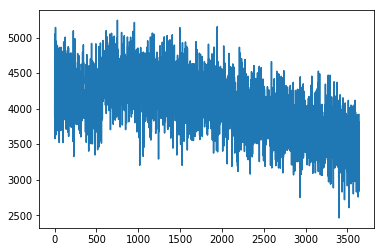

In [254]:
from matplotlib import pyplot as plt
plt.plot(losses)

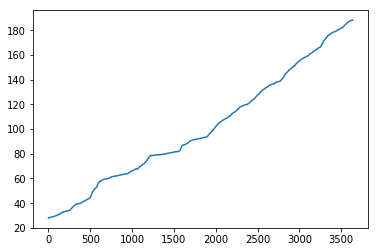

In [255]:
plt.plot(grads)
# grads[-1]